<div class="alert alert-success">  
    
-------
# XArray 101 🌍  
-------
* Jupyter and Python Basics
* Xarray Intro
* Xarray Advanced
* __Data Catalog__
* Vector Data
* Remote Sensing
* Visualization

-------  
</div>

# A better way to access data : Intake

... this great notebook is based on the awesome [PANGEO](https://pangeo.io) tutorial available [here](https://github.com/pangeo-data/pangeo-tutorial-gallery/blob/master/intake.ipynb).

<img src="https://intake.readthedocs.io/en/latest/_static/images/logo.png" alt="logo" width="200" style="float: right; margin: 10px 15px 15px 10px;"/>

> [Intake](https://intake.readthedocs.io/en/latest/index.html) is a lightweight package for finding, investigating, loading and disseminating data. This notebook 
> illutrates the usefulness of intake for a "Data User". Intake simplifies loading data from [many formats](https://intake.readthedocs.io/en/latest/plugin-directory.html#plugin-directory) into familiar Python objects like Pandas DataFrames or Xarray
> Datasets. Intake is especially useful for remote
datasets - it allows us to bypass downloading data and instead load directly into a Python object for analysis.


**Before you start:**
You need to add yet another package to our xarray-101 environment. Please call:
`conda install -y -c conda-forge intake-stac`
on your terminal once you've activated the `xarray-101` conda environment...


## Build an intake catalog

In [1]:
import intake
import xarray

print(intake.__version__)
xarray.set_options(display_style="html")

0.6.0


Download some data from the web...

In [2]:
# Save data locally from our queries
import pandas as pd
import geopandas as gpd

server = 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?'
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'
df = pd.read_csv(server+query)
df.to_csv('votw.csv', index=False)

# Or save as geojson
# Now load query results as json directly in geopandas
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=json'
gf = gpd.read_file(server+query)
gf.to_file('votw.geojson', driver='GeoJSON')

In [3]:
%%writefile votw-intake-catalog.yaml

metadata:
  version: 1

sources:
  votw_pandas:
    args:
      csv_kwargs:
        blocksize: null #prevent reading in parallel with dask
      #urlpath: 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'
      urlpath: './votw.csv'
    description: 'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'
    driver: csv
    metadata:
      citation: 'Global Volcanism Program, 2013. Volcanoes of the World, v. 4.8.4. Venzke, E (ed.). Smithsonian Institution. Downloaded 06 Dec 2019. https://doi.org/10.5479/si.GVP.VOTW4-2013'
      plots:
        last_eruption_year:
          kind: violin
          by: 'Region'
          y: 'Last_Eruption_Year'
          invert: True
          width: 700
          height: 500
            
            
  votw_geopandas:
    args:
      #urlpath: 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=json'
      urlpath: './votw.geojson'
    description: 'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'
    driver: geojson
    metadata:
      citation: 'Global Volcanism Program, 2013. Volcanoes of the World, v. 4.8.4. Venzke, E (ed.). Smithsonian Institution. Downloaded 06 Dec 2019. https://doi.org/10.5479/si.GVP.VOTW4-2013'

Overwriting votw-intake-catalog.yaml


> We now have a data catalog created, but ideally we'd host this file somewhere online where people could get access to (even just in a GitHub repo). 
> This way we can easily share data access info and also version control data access!

## Intake basics: data exploration and access

We now open the catalog and inspect it...

In [4]:
# open the catalog
cat = intake.open_catalog('votw-intake-catalog.yaml')

In [5]:
print(list(cat))
cat.votw_pandas.description

['votw_pandas', 'votw_geopandas']


'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'

Intake supports various *container* objects that we already know (arrays: xarray, dataframes: pandas, ...). Some of them might require that you install extra packages (i.e. `intake-xarray`). We can inspect the container type like so:

In [6]:
cat.votw_pandas.container

'dataframe'

To read simply call `read()` on the catalog item:

In [7]:
df = cat.votw_pandas.read()
df.head()

FID  Volcano_Number  \
0  Smithsonian_VOTW_Holocene_Volcanoes.fid--71eae...          210010   
1  Smithsonian_VOTW_Holocene_Volcanoes.fid--71eae...          210020   
2  Smithsonian_VOTW_Holocene_Volcanoes.fid--71eae...          210030   
3  Smithsonian_VOTW_Holocene_Volcanoes.fid--71eae...          210040   
4  Smithsonian_VOTW_Holocene_Volcanoes.fid--71eae...          211003   

                Volcano_Name Primary_Volcano_Type  Last_Eruption_Year  \
0  West Eifel Volcanic Field              Maar(s)             -8300.0   
1            Chaine des Puys         Lava dome(s)             -4040.0   
2        Olot Volcanic Field  Pyroclastic cone(s)                 NaN   
3   Calatrava Volcanic Field  Pyroclastic cone(s)             -3600.0   
4                    Vulsini              Caldera              -104.0   

   Country                                 Geological_Summary  \
0  Germany  The West Eifel Volcanic Field of western Germa...   
1   France  The Chaîne des Puys, prominent in the history ...   
2    Spain  The Olot volcanic field (also known as the Gar...   
3    Spain  The Calatrava volcanic field lies in central S...   
4    Italy  The Vulsini volcanic complex in central Italy ...   

                           Region       Subregion  Latitude  Longitude  \
0  Mediterranean and Western Asia  Western Europe    50.170       6.85   
1  Mediterranean and Western Asia  Western Europe    45.775       2.97   
2  Mediterranean and Western Asia  Western Europe    42.170       2.53   
3  Mediterranean and Western Asia  Western Europe    38.870      -4.02   
4  Mediterranean and Western Asia           Italy    42.600      11.93   

   Elevation                               Tectonic_Setting Geologic_Epoch  \
0        600        Rift zone / Continental crust (> 25 km)       Holocene   
1       1464        Rift zone / Continental crust (> 25 km)       Holocene   
2        893       Intraplate / Continental crust (> 25 km)       Holocene   
3       1117       Intraplate / Continental crust (> 25 km)       Holocene   
4        800  Subduction zone / Continental crust (> 25 km)       Holocene   

   Evidence_Category                                 Primary_Photo_Link  \
0     Eruption Dated  https://volcano.si.edu/gallery/photos/GVP-0150...   
1     Eruption Dated  https://volcano.si.edu/gallery/photos/GVP-0880...   
2  Evidence Credible  https://volcano.si.edu/gallery/photos/GVP-1199...   
3     Eruption Dated  https://volcano.si.edu/gallery/photos/GVP-1185...   
4  Eruption Observed  https://volcano.si.edu/gallery/photos/GVP-0150...   

                               Primary_Photo_Caption  \
0  The lake-filled Weinfelder maar is one of abou...   
1  The central part of the Chaîne des Puys volcan...   
2  The forested Volcà Montolivet scoria cone rise...   
3  Columba volcano, the youngest known vent of th...   
4  The 16-km-wide Bolsena caldera containing Lago...   

                                Primary_Photo_Credit  \
0  Photo by Richard Waitt, 1990 (U.S. Geological ...   
1       Photo by Ichio Moriya (Kanazawa University).   
2            Photo by Puigalder (Wikimedia Commons).   
3  Photo by Rafael Becerra Ramírez, 2006 (Univers...   
4  Photo by Richard Waitt, 1985 (U.S. Geological ...   

                    Major_Rock_Type          GeoLocation  
0                           Foidite   POINT (50.17 6.85)  
1             Basalt / Picro-Basalt  POINT (45.775 2.97)  
2  Trachybasalt / Tephrite Basanite   POINT (42.17 2.53)  
3             Basalt / Picro-Basalt  POINT (38.87 -4.02)  
4           Trachyte / Trachydacite   POINT (42.6 11.93)

## Predefined plots

A neat feature of intake catalogs are `predefined plots`. For data providers this allows them to publish a *sneak peak* into the data and for the users to get an impression about what this data/ some of this data looks like...

In [8]:
# This requires hvplot
import hvplot.pandas
source = cat.votw_pandas
source.plot.last_eruption_year()

:Violin   [Region]   (Last_Eruption_Year)

In [9]:
# Load a different dataset in the same catalog
source = cat.votw_geopandas
source.description

'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'

In [10]:
gf = source.read()
test = gf.loc[:,['Last_Eruption_Year', 'Volcano_Name', 'geometry']]
test.hvplot.points(geo=True, hover_cols=['Volcano_Name'], color='Last_Eruption_Year')

:Points   [Longitude,Latitude]   (Last_Eruption_Year,Volcano_Name)

## Intake xarray

We've seen a plugin to load geospatial vector data into geopandas geodataframes, there is also a plugin to facilitate loading geospatial raster data into xarray dataarrays! https://github.com/intake/intake-xarray

In [11]:
# load a catalog stored on github
xcat = intake.open_catalog('https://raw.githubusercontent.com/intake/intake-xarray/master/examples/catalog.yml')
display(list(xcat))

['esgf',
 'geotiff',
 'image',
 'images_labelled',
 'images_unlabelled',
 'grib_thredds']

In [12]:
geotiff = xcat.geotiff
geotiff.plot.band_image()

:DynamicMap   [band]
   :Image   [x,y]   (value)

In [13]:
da = geotiff.read()  # to xarray.DataArray
da.max('band')

<xarray.DataArray (y: 300, x: 300)>
array([[1819., 2596., 2495., ..., 2429., 1785., 2023.],
       [2259., 2359., 1885., ..., 2158., 1684., 1921.],
       [2865., 2291., 2664., ..., 2302., 2055., 2057.],
       ...,
       [3081., 2679., 2612., ..., 2499., 2098., 1395.],
       [2779., 2544., 2779., ..., 1429., 1596., 1496.],
       [3183., 2309., 2679., ..., 3067., 3802., 2665.]])
Coordinates:
  * y        (y) float64 4.309e+06 4.309e+06 4.309e+06 ... 4.264e+06 4.264e+06
  * x        (x) float64 3.324e+05 3.326e+05 3.327e+05 ... 3.771e+05 3.772e+05

## Intake STAC

Instead of creating your own metadata catalogs from scratch as YAML files, intake plugins exist to read catalogs in different formats. For example, for geospatial data on the web, [SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org/) are emerging as a standard way to descripe data that you want to search for based on georeference location, time, and perhaps other metadata fields. The intake-stac plugin greatly facilitates loading datasets referenced in STAC catalogs into Python Xarray objects for analysis. https://github.com/pangeo-data/intake-stac


The following data is from the open-access [Planet Disaster](https://planet.stac.cloud/?t=catalogs) data catalog hosted at https://raw.githubusercontent.com/cholmes/sample-stac/master/stac/catalog.json.
STAC metadata is organized into a hierarchy of Catalogs, Collections, and Items. Items ultimately hold Assets which are data files such as satellite raster images. Ultimately the goal of intake-STAC is to facilitate loading these Assets directly into Python objects for interactive computation without worrying about filepaths and URLs.

We'll start by connecting to the STAC Catalog for planet-disaster-data. We read the top-level catalog.json file and drill down until we get to specific STAC Items.

In [14]:
# Load root catalog
url = 'https://raw.githubusercontent.com/cholmes/sample-stac/master/stac/catalog.json'
cat = intake.open_stac_catalog(url)
print(cat.name)

# This lists available subcatalogs:
list(cat)

planet-disaster-data


['hurricane-harvey']

In [15]:
# STAC files are in JSON format, which is accessible as Python dictionaries:
cat.metadata

{'stac_version': '1.0.0-beta.1',
 'id': 'planet-disaster-data',
 'title': 'Planet Disaster Data',
 'description': '[Planet Disaster Data](https://www.planet.com/disasterdata/) makes imagery available directly to the public, volunteers, humanitarian organizations, and other coordinating bodies in support of the International Charter for Space and Major Disasters. Data is released for individual disaster events, providing a 30 day window pre- and post-disaster. Imagery is provided under Creative Commons licenses, free of charge, with either CC-BY-SA or CC-BY-NC.',
 'keywords': ['disaster', 'open'],
 'license': 'CC-BY-SA-4.0',
 'providers': [{'name': 'Planet',
   'roles': ['producer', 'processor'],
   'description': 'Contact Planet at [planet.com/contact-sales](https://www.planet.com/contact-sales/)',
   'url': 'http://planet.com'},
  {'name': 'Planet Disaster Team',
   'roles': ['licensor'],
   'description': 'The Planet Disaster Data Team (<disaster-team@planet.com>) has released this d

In [16]:
# Drill down into subcatalogs
subcat = cat['hurricane-harvey']
list(subcat)

['hurricane-harvey-0831']

In [17]:
# Another subcatalog!
subcat1 = subcat['hurricane-harvey-0831']
list(subcat1)

['20170831_172754_101c',
 '2017831_195552_SS02',
 '20170831_195425_SS02',
 '20170831_162740_ssc1d1',
 'Houston-East-20170831-103f-100d-0f4f-RGB']

In [18]:
# Load a STAC Item
item = subcat1['Houston-East-20170831-103f-100d-0f4f-RGB']

In [19]:
item.metadata

{'datetime': datetime.datetime(2017, 8, 31, 17, 24, 57, 555491, tzinfo=tzutc()),
 'constellation': 'planetscope',
 'instruments': ['PS2'],
 'gsd': 3.7,
 'eo:cloud_cover': 2,
 'view:sun_azimuth': 145.5,
 'view:sun_elevation': 64.9,
 'view:off_nadir': 0.2,
 'proj:epsg_code': 32615,
 'pl:ground_control': True,
 'bbox': [-95.73737276800716,
  29.561332400220497,
  -95.05332428370095,
  30.157560439570304],
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-95.73737276800716, 30.14525788823348],
    [-95.06532619920118, 30.157560439570304],
    [-95.05332428370095, 29.57334931237589],
    [-95.7214758280382, 29.561332400220497],
    [-95.73737276800716, 30.14525788823348]]]},
 'date': datetime.date(2017, 8, 31),
 'catalog_dir': ''}

In [20]:
# Item Assets are accessible via lists just like subcatalogs:
list(item)

['thumbnail', 'mosaic']

In [21]:
item['thumbnail'].metadata

{'href': 'https://storage.googleapis.com/pdd-stac/disasters/hurricane-harvey/0831/Houston-East-20170831-103f-100d-0f4f-3-band.png',
 'title': 'Thumbnail',
 'roles': ['thumbnail'],
 'type': 'image/png',
 'plots': {'thumbnail': {'kind': 'rgb',
   'x': 'x',
   'y': 'y',
   'bands': 'channel',
   'data_aspect': 1,
   'flip_yaxis': True,
   'xaxis': False,
   'yaxis': False}},
 'catalog_dir': ''}

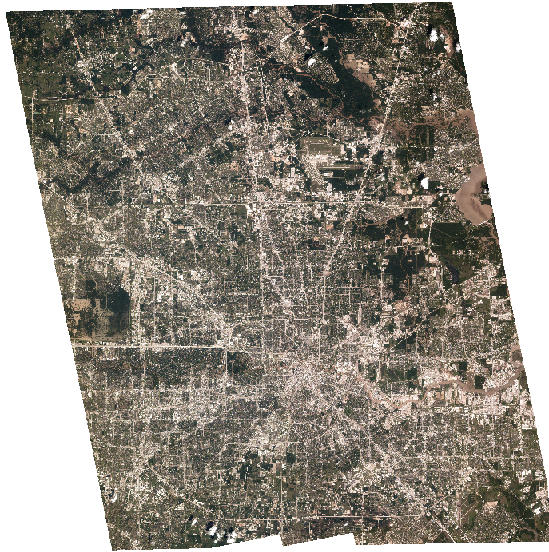

In [22]:
# Finally we can display an image!
from IPython.display import Image
Image(item['thumbnail'].urlpath)

In [23]:
# Or we can load the image directly into Xarray for analysis
# The full resolution image is big, but we use dask behind the scenes to only read metadata at first
asset = item['mosaic']
da = asset.to_dask()
da

<xarray.DataArray (band: 3, y: 22094, x: 21984)>
dask.array<open_rasterio-501c37a1d96e315c20253204d9aec1ce<this-array>, shape=(3, 22094, 21984), dtype=uint8, chunksize=(3, 22094, 21984), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 3.524e+06 3.524e+06 3.524e+06 ... 3.447e+06 3.447e+06
  * x        (x) float64 -1.066e+07 -1.066e+07 ... -1.058e+07 -1.058e+07
Attributes:
    transform:               (3.4638558402435815, 0.0, -10657435.586420376, 0...
    crs:                     +init=epsg:3857
    res:                     (3.4638558402435815, 3.4638558402435815)
    is_tiled:                1
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_DATETIME:        2017:09:01 15:10:49
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        Adobe Photoshop CC 2015.5 (Macintosh)
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72

In [24]:
# The chunk structure isn't set by default
# setting a chunk structure makes operating on subsets of pixels more efficient
da = da.chunk(dict(band=1, x=2560, y=2560))
da

<xarray.DataArray (band: 3, y: 22094, x: 21984)>
dask.array<rechunk-merge, shape=(3, 22094, 21984), dtype=uint8, chunksize=(1, 2560, 2560), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 3.524e+06 3.524e+06 3.524e+06 ... 3.447e+06 3.447e+06
  * x        (x) float64 -1.066e+07 -1.066e+07 ... -1.058e+07 -1.058e+07
Attributes:
    transform:               (3.4638558402435815, 0.0, -10657435.586420376, 0...
    crs:                     +init=epsg:3857
    res:                     (3.4638558402435815, 3.4638558402435815)
    is_tiled:                1
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_DATETIME:        2017:09:01 15:10:49
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        Adobe Photoshop CC 2015.5 (Macintosh)
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72

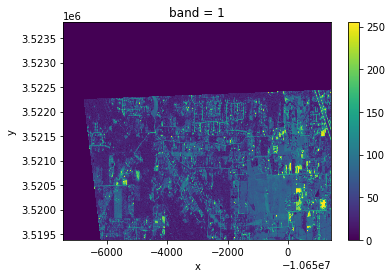

In [25]:
da.isel(band=0, x=slice(0, 2560), y=slice(0, 1280)).plot.imshow()
